Download the data from the dataset MedMNIST

In [ ]:
!pip install medmnist #dataset Path from MedMNIST

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

Download the useful libraries for the program

In [ ]:
import random
#import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

#for the progress bar
from tqdm.notebook import tqdm

#torch modules for the marchine learning
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import DataLoader#, random_split# random_split ?
from torchvision import transforms as T, datasets

#dataset Path from MedMNIST
import medmnist
from medmnist import PathMNIST #designed to work with pytorch https://github.com/MedMNIST/MedMNIST -> papers to cite at the end of the article
from medmnist import INFO#, Evaluator

Fix the same seed to all sources of randomness to enable the reproducibility of the program

In [ ]:
def fix_random(seed: int) -> None:
    """
    Fix all the possible sources of randomness
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(115)
#cite https://colab.research.google.com/drive/1SctjEG2BmgsGcLuRxMIaKw81fj70pKdA, https://www.google.com/url?q=https%3A%2F%2Fuvadlc.github.io

Creation of the different datasets from PathMNIST.

In [ ]:

info = INFO['pathmnist']
DataClass = getattr(medmnist, info['python_class'])
BATCH_SIZE=256

# load the data
preprocessing=T.Compose([T.ToTensor(), T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])#we work with pytorch, hence with tensors. Normalizing the values is a common method, we normalize the values on the 3 chanels of the images
train_dataset = DataClass(split='train', transform=preprocessing, download=True)
val_dataset = DataClass(split='val', transform=preprocessing, download=True)
test_dataset = DataClass(split='test', transform=preprocessing, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)



#https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb does not use the same opening functions !

#citations in https://zenodo.org/records/10519652 adapted here to work with pytorch


100%|██████████| 206M/206M [01:16<00:00, 2.68MB/s]


In [ ]:
'''
print(info) #info is a dictionary
print(info.keys())
train_dataset.montage(length=1)
#https://www.kaggle.com/code/mubtasimahasan/pathmnist-image-classification-cnnmodels-pytorch
'''

'\nprint(info) #info is a dictionary\nprint(info.keys())\ntrain_dataset.montage(length=1)\n#https://www.kaggle.com/code/mubtasimahasan/pathmnist-image-classification-cnnmodels-pytorch\n'



**INFO returns a description of all the dataset given by PathMNIST :**





> 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center.

> The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',

* 'url':
> 'https://zenodo.org/records/10519652/files/pathmnist.npz?download=1'



* 'MD5': 'a8b06965200029087d5bd730944a56c1',

* 'url_64':
> 'https://zenodo.org/records/10519652/files/pathmnist_64.npz?download=1',

* 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616',

* 'url_128':
>'https://zenodo.org/records/10519652/files/pathmnist_128.npz?download=1',

* 'MD5_128': 'ac42d08fb904d92c244187169d1fd1d9',

* 'url_224':
>'https://zenodo.org/records/10519652/files/pathmnist_224.npz?download=1',

* 'MD5_224': '2c51a510bcdc9cf8ddb2af93af1eadec',

* 'task': 'multi-class',

* **'label'**: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'},

* **'n_channels'**: 3,

* 'n_samples': {'train': 89996, 'val': 10004, 'test': 7180},

* 'license': 'CC BY 4.0'

We can verify the size of the input data.
* train_data contains 2 major lists, one with the images, and one with the labels.
* If we look at the size of the first image, we obtain a tensor of an image 28*28 with 3 chanels, what was declared in the documentation of PathMNIST.

In [ ]:
input_dim =train_dataset[0][0]#size of input images
print(input_dim.shape)

torch.Size([3, 28, 28])


A first overview : we look at the distributions of 10 different classes in the training, validation and test sets

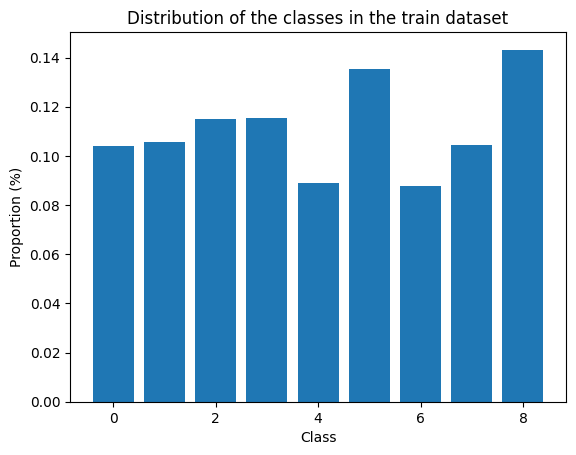

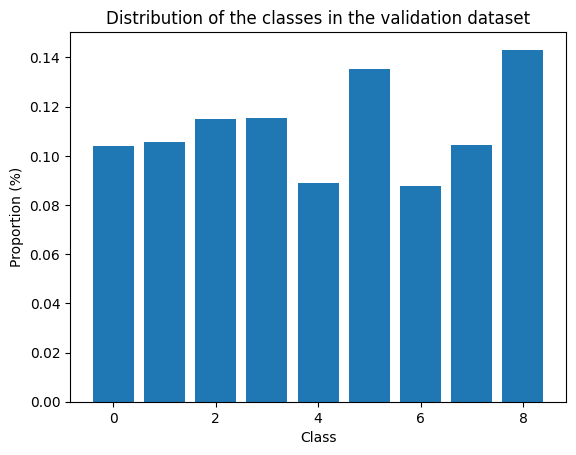

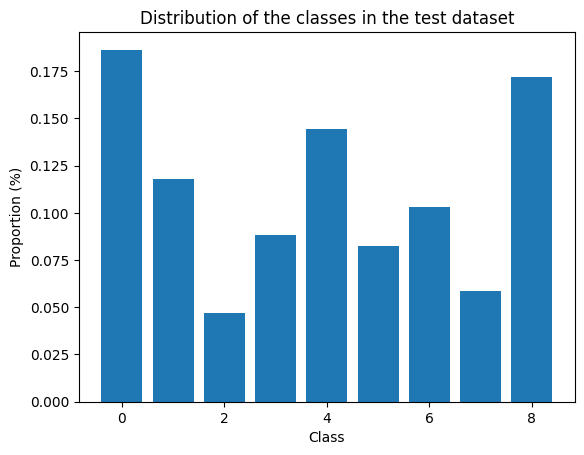

In [ ]:

num_classes=len(info['label'])
d={'train dataset' : train_loader, 'validation dataset' : val_loader, 'test dataset' : test_loader}

for name, dataset in d.items():
  distribs=torch.zeros(num_classes, dtype=torch.int64)
  for inputs, labels in dataset:
    labels = labels.view(-1)
    distribs +=  torch.bincount(labels, minlength=num_classes)

  tot=distribs.sum()
  dist=distribs/tot
  hist=torch.histogram(distribs/distribs.sum(), bins=num_classes)
  plt.bar(range(num_classes), dist.numpy())
  plt.title(f'Distribution of the classes in the {name}')
  plt.xlabel('Class')
  plt.ylabel('Proportion (%)')
  plt.show()

We can see that the values are distributed in equal proportions in the training and validation sets. The test set comes from another source, thus the distribution differs.

> https://doi.org/10.1371/journal.pmed.1002730

***Declaration of the cuda device enables to run the algorithm faster***

Since the computational time explode very quickly with the number of parameters induced in the convolutional neural network (CNN), we need to optimize the algorithm as much as we can.

In [ ]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") #we try to connect to the GPU 'cuda'
print(f"Device: {device}")

Is the GPU available? True
Device: cuda


**CNN model**

* We declare a model of CNN constitued of 5 layers, each one is composed of a convolutional transform, a normalization and introduce non-linearity to make sure the neural network will not backtrack.
* The final layer also compute a convolution, but taking a final flatten vector, return a vector of 9 values, probably representing the probabilities for each image to belong to each of the class.

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_Model, self).__init__()

        self.main = nn.Sequential(
            #layer 1
            nn.Conv2d(in_channels, 28, kernel_size=4, stride=1, padding=2, bias=False),#in_channels=3 : size of images 28*28*28, out = 28 matrix 29*29
            nn.BatchNorm2d(28),
            nn.ReLU(),#non_linearity
            #layer 2
            nn.Conv2d(28, 56, kernel_size=3, stride=2, padding=3, bias=False),# out = 56 matrix 17*17, first/last column and rows of zeros because kernel_size=padding
            nn.BatchNorm2d(56),
            nn.ReLU(),
            #layer 3
            nn.Conv2d(56, 112, kernel_size=5, stride=2, padding=0, bias=False),# out = 112 matrix 7*7, padding=0 we already have a matrix surrounded by zeros
            nn.BatchNorm2d(112),
            nn.ReLU(),
            #layer 4
            nn.Conv2d(112, 228, kernel_size=3, stride=2, padding=1, bias=False),# out = 228 matrix 4*4
            nn.BatchNorm2d(228),
            nn.ReLU(),
            #layer 5, replace by an average (see IPCV)
            nn.Conv2d(228, 456, kernel_size=4, padding=0, bias=False),# out = 456 matrix 1*1
            nn.AdaptiveAvgPool2d((1,1)),#make sure to have 456*1*1 format if we change the parameters in the previous layers, but returns [batch_size, 456, 1, 1]
            nn.Flatten(),#returns [batch_size, 456]
            nn.Linear(456, num_classes)
        )

    def forward(self, input):
        return self.main(input)

#nn.Module documentation : https://github.com/tylergenter/pytorch/blob/master/torch/nn/modules/module.py

We assign the model and we send it to the GPU if it is available

In [ ]:
n_channels = len(input_dim)
n_classes = len(info['label'])
n_epochs=5
lr=0.001

model = CNN_Model(in_channels=n_channels, num_classes=n_classes)
model.to(device)

CNN_Model(
  (main): Sequential(
    (0): Conv2d(3, 28, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(28, 56, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
    (4): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(56, 112, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (7): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(112, 228, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(228, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(228, 456, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): AdaptiveAvgPool2d(output_size=(1, 1))
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=456, out_featur

Loss function

In [ ]:
optimizer = Adam(model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()

model.compile()

In [ ]:
def train_function(model, input_train, input_val, n_epochs, optimizer):
  # creation of the lists to output: loss and AUC for the train and validation set
  current_loss_list=[]
  current_loss_val_list=[]
  auc_list=[]
  auc_val_list=[]
  score_list_tot=[]

  for e in tqdm(range(n_epochs)):
    real_val_list=[]#list of the real values
    score_list=[]#list of the predicted values

    #training part of the model
    model.train()
    current_loss=0
    for batch in tqdm(input_train):
      image=batch[0].to(device)
      real_val=batch[1].to(device)

      score=model(image)
      real_val = real_val.squeeze(1)
      loss_value=loss(score, real_val)
      s=score.softmax(dim=1)
      score_list.extend(s.detach().cpu().numpy())
      real_val_list.extend(real_val.detach().cpu().numpy())

      #compute the loss
      optimizer.zero_grad()
      loss_value.backward()
      optimizer.step()
      current_loss+=loss_value

    # Convert to numpy arrays for roc_auc_score
    real_val_np = np.array(real_val_list)
    score_np = np.array(score_list)

    # Compute AUC for multi-class
    auc = roc_auc_score(real_val_np, score_np, multi_class='ovr')
    auc_list.append(auc)
    current_loss_list.append(current_loss)

    #evaluation of the model
    model.eval()
    with torch.no_grad():
      current_loss_val=0
      real_val_list=[]
      score_list=[]
      for batch in tqdm(input_val):
        image=batch[0].to(device)
        real_val=batch[1].to(device)
        score=model(image)
        real_val = real_val.squeeze(1)
        loss_value=loss(score, real_val)
        s=score.softmax(dim=1)
        score_list.extend(s.detach().cpu().numpy())
        real_val_list.extend(real_val.detach().cpu().numpy())
        current_loss_val+=loss_value

      real_val_np = np.array(real_val_list)
      score_np = np.array(score_list)

      auc_val = roc_auc_score(real_val_np, score_np, multi_class='ovr')
      auc_val_list.append(auc_val)
      current_loss_val_list.append(current_loss_val)
      score_list_tot.append(score_np)

    print('for epoch n°',e+1, ', training AUC : ', auc, ' and validation AUC : ', auc_val)
  return current_loss_list, current_loss_val_list, auc_list, auc_val_list, score_list_tot, real_val_list


In [ ]:
'''
print(train_loader)
for batch in train_loader :
  inputs, labels = batch
  print(type(labels))
  print(labels.shape)
  print(labels.dtype)
'''

'\nprint(train_loader)\nfor batch in train_loader :\n  inputs, labels = batch\n  print(type(labels))\n  print(labels.shape)\n  print(labels.dtype)\n'

We can test the robustness of the model while changing the seed

In [ ]:
seeds=np.array([100, 200, 300])#np.random.randint(500, size=20) if we want more seeds
results=[]


for seed in seeds :
  print('seed :', seed)
  fix_random(int(seed))
  model = CNN_Model(in_channels=n_channels, num_classes=n_classes)
  model.to(device)
  optimizer = Adam(model.parameters(), lr=lr)
  loss = torch.nn.CrossEntropyLoss()

  loss_test, loss_val, train_auc, val_auc, score_list, real_val_list = train_function(
    model,
    train_loader,
    val_loader,
    n_epochs,
    optimizer,
  )
  results.append((seed, train_auc, val_auc))

seed : 100


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9622869288431103  and validation AUC :  0.9841823452166754


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9885878445422155  and validation AUC :  0.9897308865359375


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9930297682994572  and validation AUC :  0.990282567319156


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9956467537148248  and validation AUC :  0.9900912259572355


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9952349669414262  and validation AUC :  0.9952524894311223
seed : 200


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9561851294422851  and validation AUC :  0.9839552165103633


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9766903723879599  and validation AUC :  0.9238327730139032


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9834727587507187  and validation AUC :  0.9740045014638059


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.990790137896291  and validation AUC :  0.9914188171336347


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9941531264421365  and validation AUC :  0.9933225213218733
seed : 300


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9636737046743394  and validation AUC :  0.9792437994158836


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9883359184993695  and validation AUC :  0.9766587414555613


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.993278584305342  and validation AUC :  0.9946010200939833


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.995168575250953  and validation AUC :  0.9886189112864615


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9955170218385947  and validation AUC :  0.9960436223060695


Visualisation of the AUC for the chosen seeds in a graphic

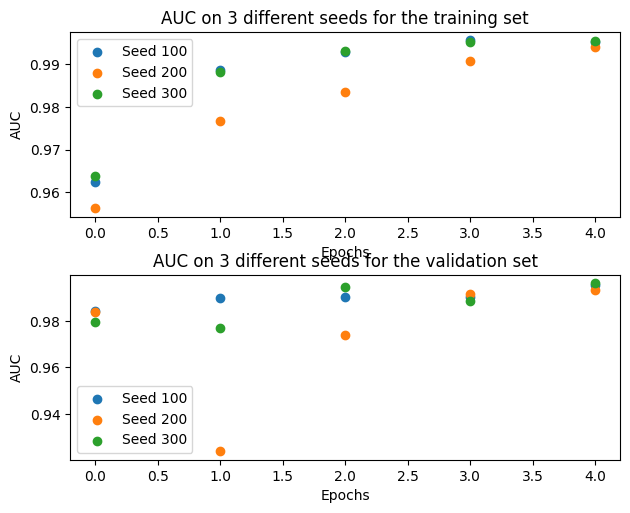

statistic values on the validation set : 
mean = 0.983415962564111
std = 0.01722050676281065


In [ ]:
seed_list, train_accs, val_accs = zip(*results)

plt.subplot(2,1,1)
for i in range(len(train_accs)):
  plt.scatter(np.arange(n_epochs), train_accs[i], label=f"Seed {seed_list[i]}")
plt.title(f'AUC on {len(seed_list)} different seeds for the training set')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()

plt.subplot(2,1,2)
for i in range(len(val_accs)):
  plt.scatter(np.arange(n_epochs),val_accs[i], label=f"Seed {seed_list[i]}")
plt.title(f'AUC on {len(seed_list)} different seeds for the validation set')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()
print('statistic values on the validation set : ' )
print(f'mean = {np.mean(val_accs)}')
print(f'std = {np.std(val_accs)}')

As a complement and to decide of the hyperparameter, we compute the loss and the AUC to visualize their evolution with the number of epochs used.

seed : 42


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9592618369297227  and validation AUC :  0.9794588629337839


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9856433598901412  and validation AUC :  0.984890296979931


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9822220346462  and validation AUC :  0.986548251067613


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9933135673017142  and validation AUC :  0.9910754631730803


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9956072262817259  and validation AUC :  0.9956026327803466


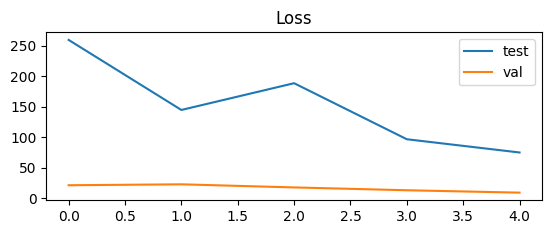

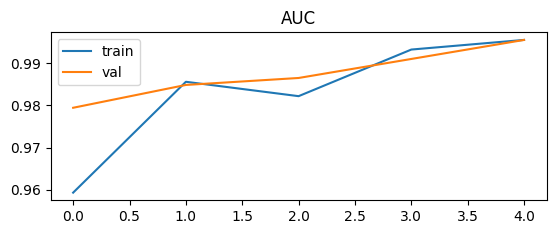

In [ ]:
x, y = train_dataset[0]
seed=42
results=[]


print('seed :', seed)
fix_random(int(seed))
model = CNN_Model(in_channels=n_channels, num_classes=n_classes)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()

loss_test, loss_val, train_acc, val_acc, score_list, real_val_list= train_function(
    model,
    train_loader,
    val_loader,
    n_epochs,
    optimizer,
  )
results.append((train_acc, val_acc))

loss_test_floats = [x.item() for x in loss_test]
loss_val_floats= [x.item() for x in loss_val]

plt.subplot(2, 1, 1)
plt.plot(loss_test_floats, label="test")
plt.plot(loss_val_floats, label="val")
plt.legend()
plt.title("Loss")
plt.show()

plt.subplot(2, 1, 2)
plt.plot(train_acc, label="train")
plt.plot(val_acc, label="val")
plt.legend()
plt.title("AUC")
plt.show()


We train the model with the development set.
(with the cuda device, it takes 45 mins for 20 seeds and 5 epochs)

In [ ]:
x, y = train_dataset[0]
seeds=np.random.randint(500, size=20)
results={}


for seed in seeds :
  print('seed :', seed)
  fix_random(int(seed))
  model = CNN_Model(in_channels=n_channels, num_classes=n_classes)
  model.to(device)
  optimizer = Adam(model.parameters(), lr=lr)
  loss = torch.nn.CrossEntropyLoss()

  loss_test, loss_val, train_acc, val_acc, score_list, real_val_list = train_function(
    model,
    train_loader,
    val_loader,
    n_epochs,
    optimizer,
  )

  results[seed] ={'loss':loss_test, 'train_acc' : train_acc, 'val_acc' : val_acc, 'predicted_val' : score_list, 'true_val' : real_val_list}



seed : 102


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9646914253278118  and validation AUC :  0.9777391282758333


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9887587122978694  and validation AUC :  0.9904510004847804


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9935358041565985  and validation AUC :  0.964479007196846


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9925039312878255  and validation AUC :  0.9895027756452218


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9962784558799831  and validation AUC :  0.9956119881237507
seed : 435


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9598239584739154  and validation AUC :  0.976704587664232


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9883025781885666  and validation AUC :  0.9848982273732444


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.992624368009881  and validation AUC :  0.9934961616051141


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.995233346284772  and validation AUC :  0.9895589918749003


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9962353780983197  and validation AUC :  0.993731155467136
seed : 348


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9646430508255812  and validation AUC :  0.9369394479227336


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9891313548768674  and validation AUC :  0.9892547731221109


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9940648893608375  and validation AUC :  0.9919486338182352


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9961340582086472  and validation AUC :  0.9879240999902943


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.997067377240185  and validation AUC :  0.9886625179263139
seed : 270


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9582382060449621  and validation AUC :  0.9820866534398959


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9863271082533418  and validation AUC :  0.9866188995499184


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9919455530937991  and validation AUC :  0.9798924099245858


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9951796868583566  and validation AUC :  0.9731016801245767


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9964707539389848  and validation AUC :  0.9810949038149042
seed : 106


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.965808638816551  and validation AUC :  0.9852945623407052


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.988591085181567  and validation AUC :  0.9899046419269024


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9937221253836941  and validation AUC :  0.9901871417365702


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9954457011682458  and validation AUC :  0.9876572093273356


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9970373379314363  and validation AUC :  0.9951743254946278
seed : 71


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.960763644004544  and validation AUC :  0.9562714883578545


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9876173049780079  and validation AUC :  0.9746663133159517


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9910399547985974  and validation AUC :  0.9937186592224266


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9956174120215712  and validation AUC :  0.993818892596162


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9969228335329527  and validation AUC :  0.9942149425957815
seed : 188


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.956177477952693  and validation AUC :  0.9751250700451417


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9855070899013233  and validation AUC :  0.9798100833512723


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9908641575366754  and validation AUC :  0.9919187073625688


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9940640833201146  and validation AUC :  0.9809430191446302


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9956079069014458  and validation AUC :  0.9903416507949735
seed : 20


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9638293221537728  and validation AUC :  0.9692359034091427


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9875638506622401  and validation AUC :  0.9677648532363785


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.991945481102604  and validation AUC :  0.9924069663254509


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.995159964824604  and validation AUC :  0.9955649074464544


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9969440881252871  and validation AUC :  0.9949847783996035
seed : 102


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9646914253278118  and validation AUC :  0.9777391282758333


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9887587122978694  and validation AUC :  0.9904510004847804


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9935358041565985  and validation AUC :  0.964479007196846


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9925039312878255  and validation AUC :  0.9895027756452218


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9962784558799831  and validation AUC :  0.9956119881237507
seed : 121


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9637304327379975  and validation AUC :  0.9803484456318442


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9879302411290259  and validation AUC :  0.9870377124941994


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9930652077916585  and validation AUC :  0.9875606686426125


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9958365649128414  and validation AUC :  0.9897453481301093


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9970078485172323  and validation AUC :  0.99555132773124
seed : 466


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9608770476040748  and validation AUC :  0.981401026587063


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9867715141268183  and validation AUC :  0.9889942589027064


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9921177674067734  and validation AUC :  0.9920277846607105


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9948616660375507  and validation AUC :  0.9845382340200971


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9964511362797146  and validation AUC :  0.9908583990565109
seed : 214


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9641405893678692  and validation AUC :  0.9859134432818042


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9881883391776175  and validation AUC :  0.9913642908918088


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9933811644401249  and validation AUC :  0.990680107132256


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9953008990427326  and validation AUC :  0.9946076684358497


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9968164600534961  and validation AUC :  0.995054663425129
seed : 330


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9637886503467961  and validation AUC :  0.9855179337459757


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9879832864341496  and validation AUC :  0.9897244911293246


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.993208925614077  and validation AUC :  0.9903641115575815


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9954066746292365  and validation AUC :  0.9924409244417599


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9968453815060916  and validation AUC :  0.9909295869344172
seed : 458


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9664403090155843  and validation AUC :  0.9848845332192643


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9891937114565883  and validation AUC :  0.9895219324111734


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9934219367052469  and validation AUC :  0.9914434341132724


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9877157068637956  and validation AUC :  0.9921737415005365


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9955920679816076  and validation AUC :  0.9931261151417886
seed : 87


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9678440489384135  and validation AUC :  0.9775730262683745


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9885153655381428  and validation AUC :  0.9913442359686289


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9936386545829848  and validation AUC :  0.9874040632253784


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9961238012372493  and validation AUC :  0.9914223936105232


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9974659305115353  and validation AUC :  0.9952281852396072
seed : 372


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.964804870704781  and validation AUC :  0.9751608199679492


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9886474740017689  and validation AUC :  0.9907791351820825


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9935193827014105  and validation AUC :  0.9939382694928527


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9955331482885948  and validation AUC :  0.9945213341615032


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9971309146228778  and validation AUC :  0.996631442558621
seed : 99


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9637364222055093  and validation AUC :  0.9827104880102568


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9874417308087953  and validation AUC :  0.9889856384810075


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9925329627008286  and validation AUC :  0.9916596847878006


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9955518616953842  and validation AUC :  0.9950832157672816


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.996887963895901  and validation AUC :  0.9953238927999117
seed : 359


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9618058858016774  and validation AUC :  0.9737570241055786


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9877639507255996  and validation AUC :  0.9877610932055014


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9930540159076541  and validation AUC :  0.9899485404292512


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9954553804444054  and validation AUC :  0.9939010267643439


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.996660061673761  and validation AUC :  0.9838597461031549
seed : 151


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9646207326161709  and validation AUC :  0.9809595234631229


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.98871052912812  and validation AUC :  0.9903170846045914


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9929192992389461  and validation AUC :  0.992970041631991


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9960179575212913  and validation AUC :  0.9948249238612661


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9970094312478158  and validation AUC :  0.9962160192091711
seed : 130


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 1 , training AUC :  0.9561821944986253  and validation AUC :  0.9691616935885019


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 2 , training AUC :  0.9862688658430003  and validation AUC :  0.9894132671582232


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 3 , training AUC :  0.9923471906393758  and validation AUC :  0.9690294080295776


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 4 , training AUC :  0.9945372192756725  and validation AUC :  0.9923822323549533


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

for epoch n° 5 , training AUC :  0.9964644903457535  and validation AUC :  0.9928888361166206


We show with graphics the evolution of the AUC for each seed, we also compute mean and standard deviation to have a reproducible value of the AUC.

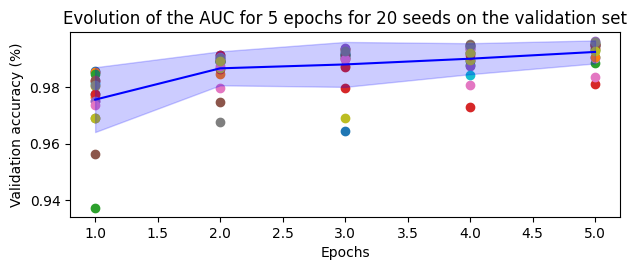

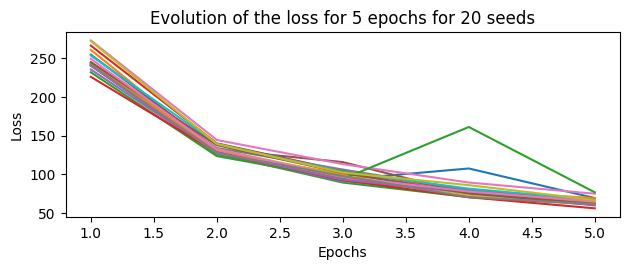

Mean and standard deviation through seeds values for the last epochs (on the validation set)
mean = 0.9866701855699077
std = 0.005864780238908119
seed used : [102 435 348 270 106  71 188  20 102 121 466 214 330 458  87 372  99 359
 151 130]


<Figure size 640x480 with 0 Axes>

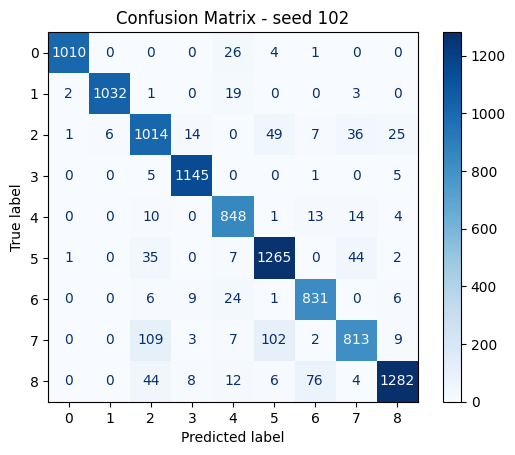

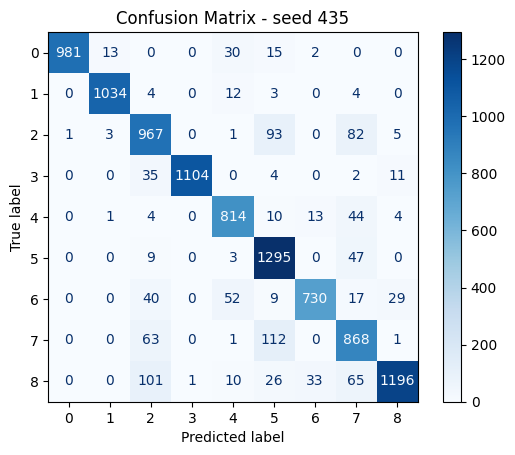

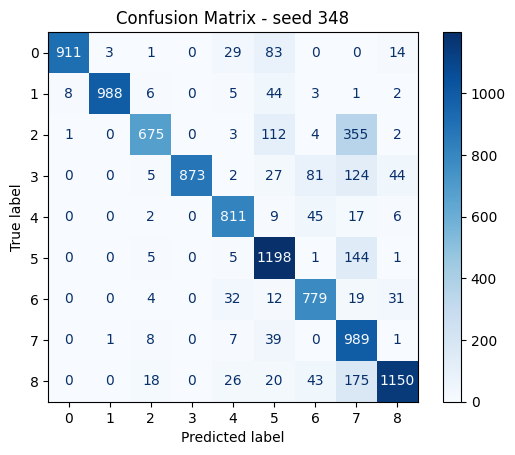

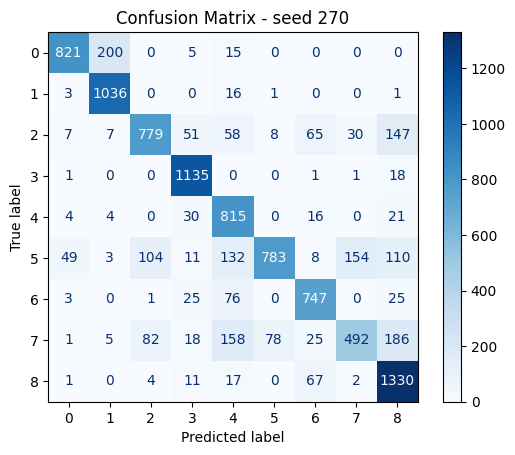

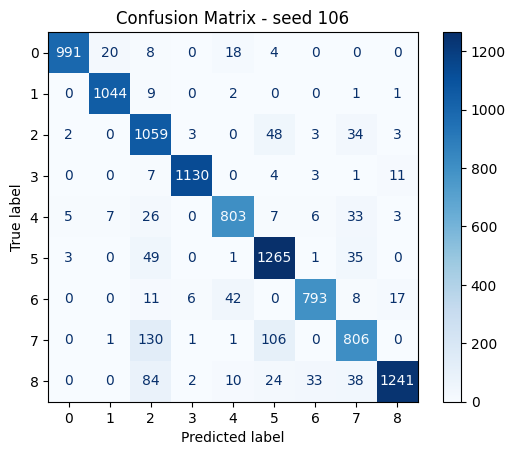

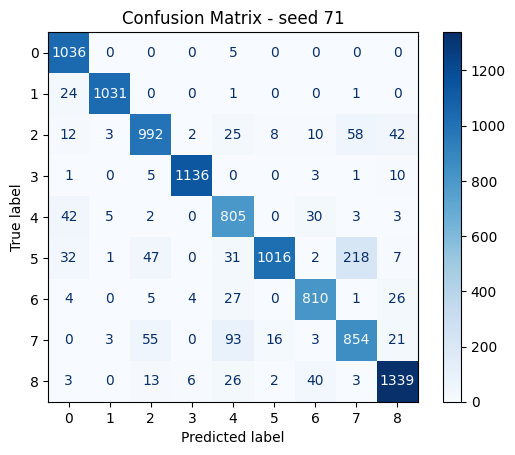

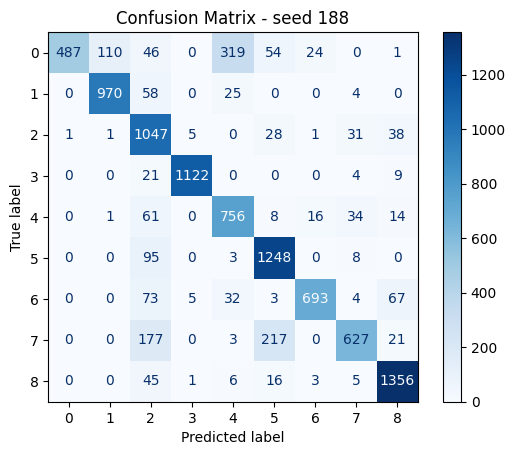

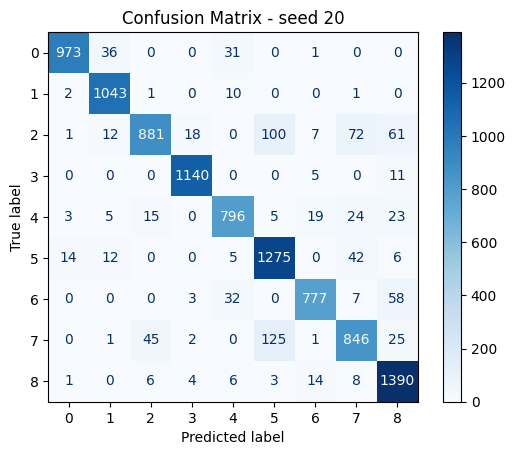

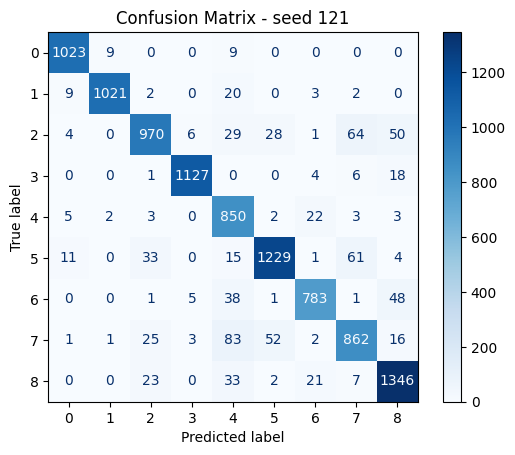

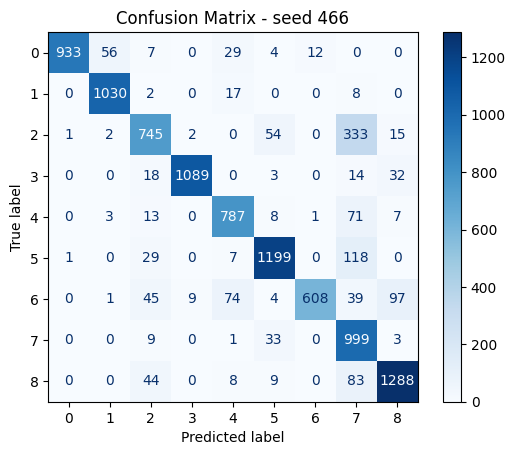

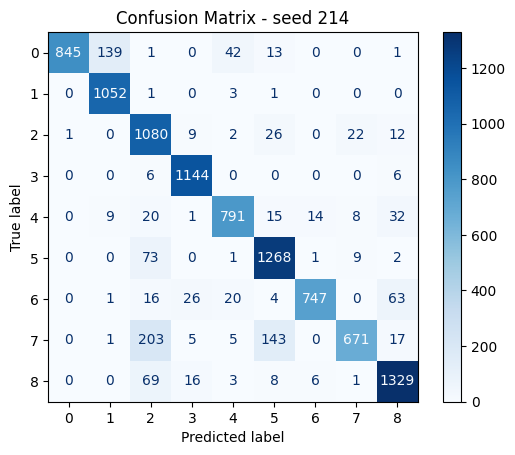

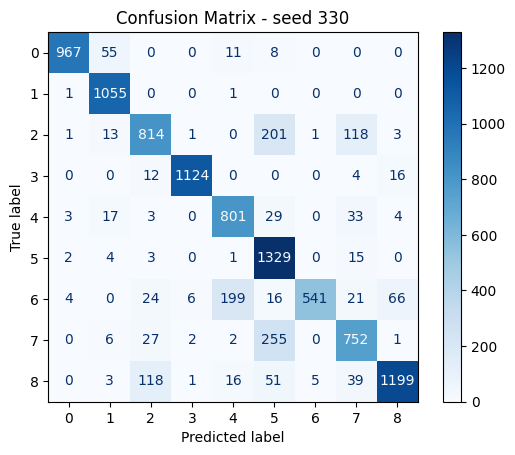

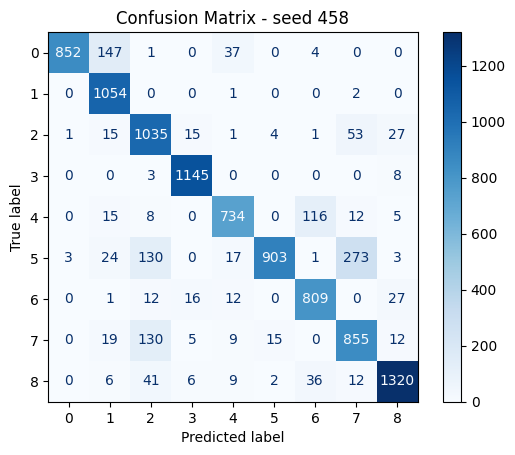

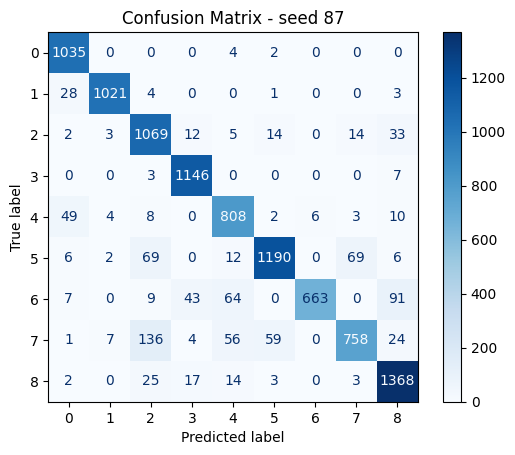

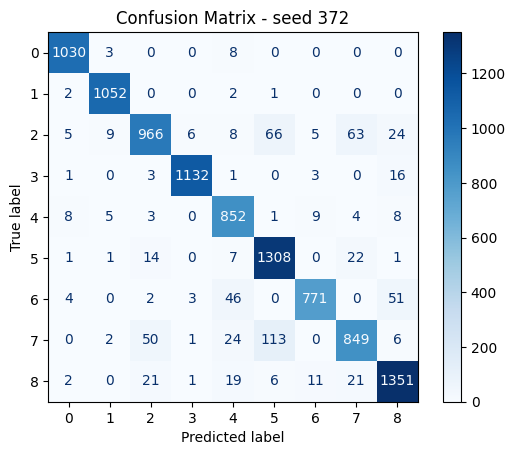

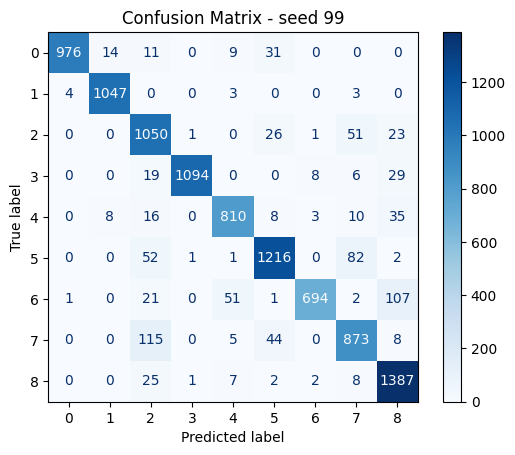

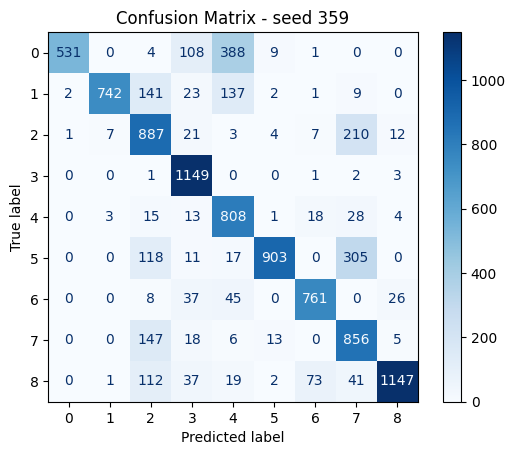

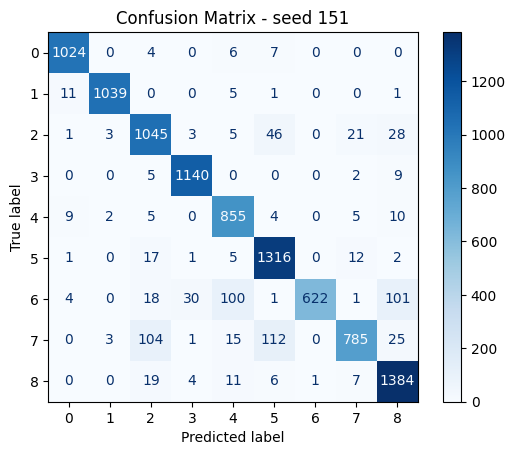

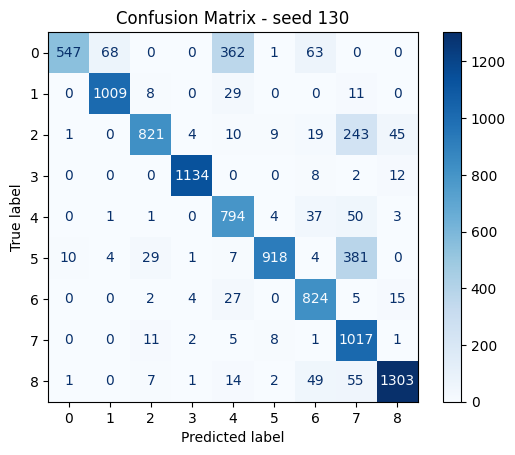

<Figure size 1200x1000 with 0 Axes>

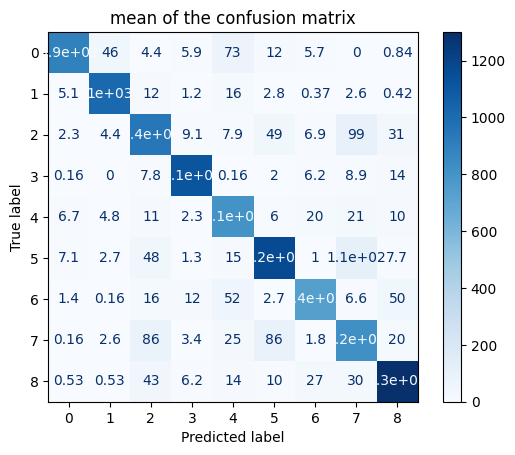

<Figure size 1200x1000 with 0 Axes>

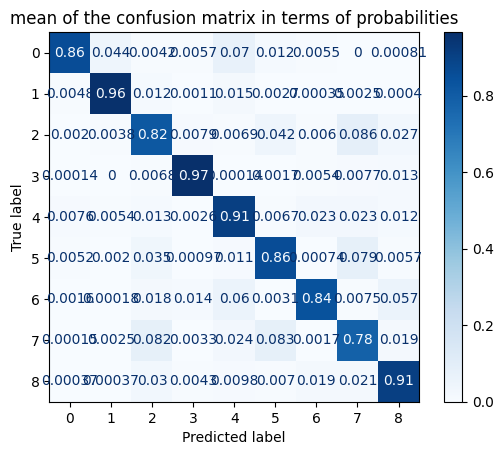

In [ ]:
epochs = range(1,n_epochs+1)
plt.figure()

val_curves = np.array([logs['val_acc'] for logs in results.values()])
mean_val = np.mean(val_curves, axis=0)
std_val = np.std(val_curves, axis=0)

plt.subplot(2,1,1)
for seed, logs in results.items():
    plt.scatter(epochs, logs['val_acc'], label=f"Seed {seed}")

plt.plot(epochs, mean_val, label="Mean Val AUC", color='blue')
plt.fill_between(epochs, mean_val - std_val, mean_val + std_val, color='blue', alpha=0.2)

plt.xlabel("Epochs")
plt.ylabel("Validation accuracy (%)")
plt.title(f'Evolution of the AUC for {n_epochs} epochs for {len(seeds)} seeds on the validation set')
#plt.legend()
plt.tight_layout()
plt.show()



plt.subplot(2,1,2)
for seed, logs in results.items():
  loss_list=logs['loss']
  loss_list_floats = [x.item() for x in loss_list]
  plt.plot(epochs, loss_list_floats, label=f"Seed {seed}")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f'Evolution of the loss for {n_epochs} epochs for {len(seeds)} seeds')
#plt.legend()
plt.tight_layout()
plt.show()

print('Mean and standard deviation through seeds values for the last epochs (on the validation set)')
print(f'mean = {np.mean(mean_val)}')
print(f'std = {np.std(mean_val)}')
print(f'seed used : {seeds}')

#visualize the confusion matrix
plt.figure()

cm_list=[]
for seed, logs in results.items():
  predict_values=np.array(logs['predicted_val'])
  #print(predict_values[n_epochs-1,0])
  #print(len(predict_values[n_epochs-1,:].argmax(axis=1)))
  true_values=logs['true_val']
  #print(np.shape(true_values))
  cm=confusion_matrix(true_values, predict_values[n_epochs-1,:].argmax(axis=1))
  cm_list.append(cm)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=info['label'])
  disp.plot(cmap=plt.cm.Blues)
  plt.title(f'Confusion Matrix - seed {seed}')
  plt.show()


confusion_matrix_mean=np.mean(np.stack(cm_list), axis=0)
confusion_matrix_standardized=confusion_matrix_mean/confusion_matrix_mean.sum(axis=1, keepdims=True)


plt.figure(figsize=(12,10))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_mean, display_labels=info['label'])
disp.plot(cmap=plt.cm.Blues)
plt.title("mean of the confusion matrix")
plt.show()

plt.figure(figsize=(12,10))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_standardized, display_labels=info['label'])
disp.plot(cmap=plt.cm.Blues)
plt.title("mean of the confusion matrix in terms of probabilities")
plt.show()

Finally, we evaluate the model with the test dataset. All the hyperparameters have already been fixed with the results obtained on the development set.

In [ ]:
def test_function(model, test_set):
    auc_list=[]
    auc_val_list=[]
    score_list_tot=[]
    #evaluation of the model
    model.eval()
    with torch.no_grad():
      #current_loss_val=0
      real_val_list=[]
      score_list=[]
      for batch in tqdm(test_set):
        image=batch[0].to(device)
        real_val=batch[1].to(device)
        score=model(image)
        real_val = real_val.squeeze(1)
        #loss_value=loss(score, real_val)
        s=score.softmax(dim=1)
        score_list.extend(s.detach().cpu().numpy())
        real_val_list.extend(real_val.detach().cpu().numpy())
        #current_loss_val+=loss_value

      real_val_np = np.array(real_val_list)
      score_np = np.array(score_list)

      auc_val = roc_auc_score(real_val_np, score_np, multi_class='ovr')
      auc_val_list.append(auc_val)
      #current_loss_val_list.append(current_loss_val)
      score_list_tot.append(score_np) #maybe .extend

    print('AUC : ', auc_val)
    return  auc_val_list, score_list_tot, real_val_list


To have an idea of the repartition of the images classified, we use the confusion matrix

  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


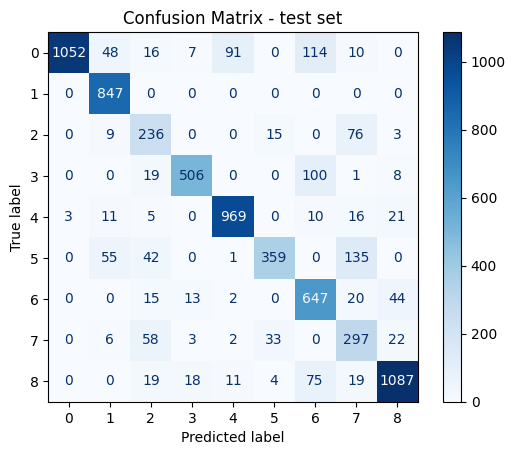

<Figure size 1200x1000 with 0 Axes>

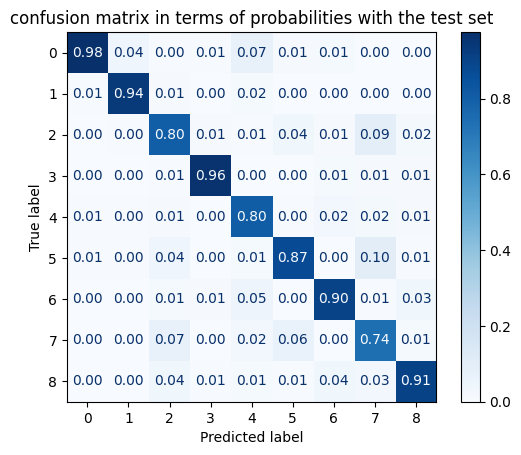

In [ ]:
auc_test, score_test, real_val_test=test_function(model, test_loader)

score_test=np.array(score_test)

score_test = np.argmax(score_test, axis=2)

cm=confusion_matrix(np.array(real_val_test).flatten(), score_test.flatten())
cm_list.append(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=info['label'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - test set')
plt.show()

confusion_matrix_mean=np.mean(np.stack(cm_list), axis=0)
confusion_matrix_standardized=confusion_matrix_mean/confusion_matrix_mean.sum(axis=0, keepdims=True)

plt.figure(figsize=(12,10))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_standardized, display_labels=info['label'])
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title("confusion matrix in terms of probabilities with the test set")
plt.show()

In [ ]:
auc_list=[]
for seed, logs in results.items():
    auc_test, score_test, real_val_test=test_function(model, test_loader)
    auc_list.append(auc_test)

print('Mean and standard deviation through seeds values (on the test set)')
print(f'mean = {np.mean(auc_list)}')
print(f'std = {np.std(auc_list)}')
print(f'seed used : {seeds}')

  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411


  0%|          | 0/29 [00:00<?, ?it/s]

AUC :  0.9762212478081411
Mean and standard deviation through seeds values (on the test set)
mean = 0.9762212478081411
std = 0.0
seed used : [102 435 348 270 106  71 188  20 102 121 466 214 330 458  87 372  99 359
 151 130]


Comparison with a RandomForest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Collect full train data
X_train = []
y_train = []

for x, y in train_dataset:
    X_train.append(np.array(x).flatten())  # flatten in case x is multi-dimensional (e.g., image or sequence)
    y_train.append(y)

X_train = np.stack(X_train)
y_train = np.array(y_train)

# Train model
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

# Collect test data
X_test = []
y_test = []

for x, y in test_dataset:
    X_test.append(np.array(x).flatten())
    y_test.append(y)

X_test = np.stack(X_test)
y_test = np.array(y_test)

# Predict
y_pred_proba = clf.predict_proba(X_test)[:, 1] if len(np.unique(y_train)) == 2 else clf.predict_proba(X_test)

# AUC score
if len(np.unique(y_train)) == 2:
    auc = roc_auc_score(y_test, y_pred_proba)
else:
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"AUC wityh the RandomForest Method: {auc:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


AUC wityh the RandomForest Method: 0.8421
